## Evaluation of Bayes model compared to loo
This notebook uses some datasets and compares the performance of 3 models.
- `loo`: The leave-one-subject-out model which simply averages the connectivity weights
- `bayes`: Uses the leave-one-subject-out manner but do weighted average across subjects accroding to their `coef_var`
- `bayes_vox`: Same as `bayes`, but does this integration for each voxel separately

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import glob
import matplotlib.pyplot as plt

In [2]:
def plot_with_error(df, x_var, y_var, title, error='se'):
    means = df.groupby(x_var)['R_eval'].mean().sort_values(ascending=True)
    ax = sns.barplot(data=df, x=x_var, y=y_var, hue=x_var, errorbar=error, order=means.index.to_list())
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(title) 
    return ax, means

### Evaluation of S1 model on S2

In [56]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
eval_data = ["MDTBs2", "WMFS02", "Nishimoto02"]
df = rm.comb_eval(models=['loo','bayes','bayes_vox'],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')

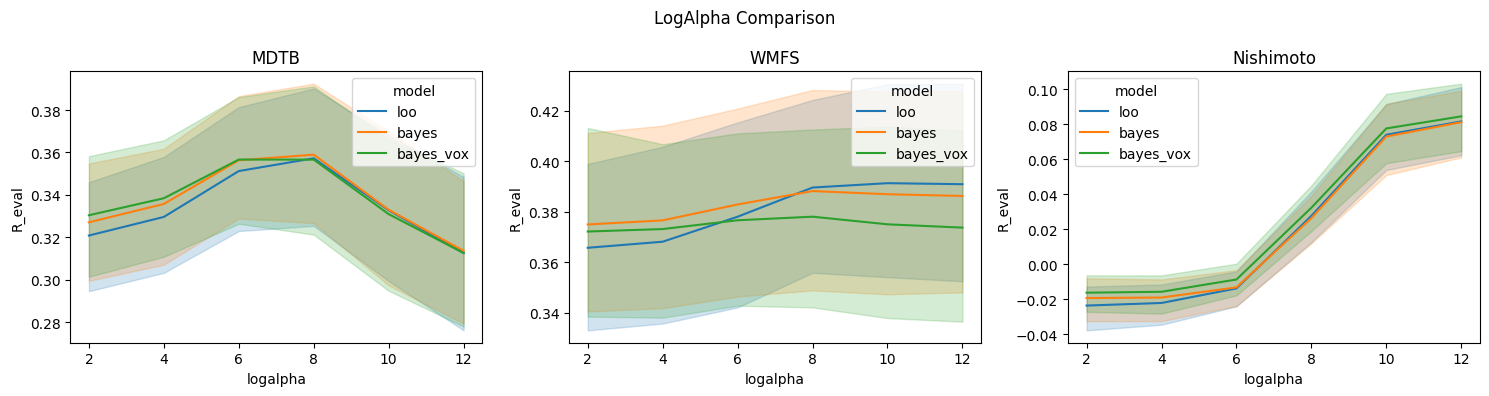

In [57]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df[df['eval_dataset'] == dataset]
    means = df_to_eval.groupby('model')['R_eval'].mean().sort_values(ascending=True)
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [59]:
A = pd.pivot_table(df,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df['isbest'] = df.logalpha.values  == bestla.loc[df.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.326112  0.334595  0.354744  0.357620  0.332221  0.312951
Nishimoto     -0.019615 -0.018847 -0.011797  0.028878  0.074951  0.082523
WMFS           0.370910  0.372581  0.379149  0.385254  0.384404  0.383604

,best_logalpha
train_dataset,
MDTB,8.0
Nishimoto,12.0
WMFS,8.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

loo vs. bayes: t-test paired samples, P_val:4.565e-02 t=-2.113e+00
bayes_vox vs. loo: t-test paired samples, P_val:6.813e-01 t=-4.160e-01
bayes_vox vs. bayes: t-test paired samples, P_val:1.638e-02 t=-2.590e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bayes vs. loo: t-test paired samples, P_val:6.774e-01 t=-4.243e-01
bayes_vox vs. bayes: t-test paired samples, P_val:2.863e-04 t=-4.697e+00
bayes_vox vs. loo: t-test paired samples, P_val:7.954e-03 t=-3.059e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ba

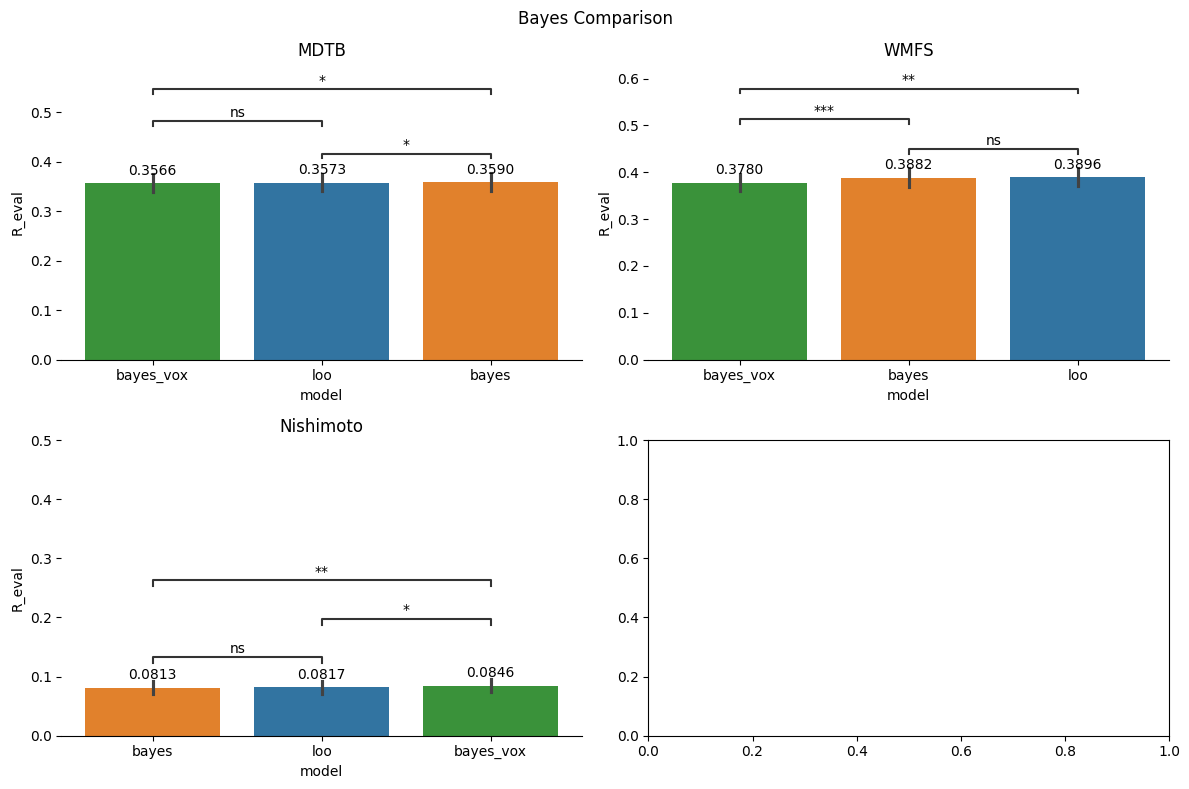

In [60]:
pairs=[('loo', 'bayes'), ('loo', 'bayes_vox'), ('bayes', 'bayes_vox')]

plt.subplots(int(np.ceil(len(dataset_list)/2)),2,figsize=(12,int(np.ceil(len(dataset_list)/2))*4))
plt.suptitle('Bayes Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/2)),2,d+1)
    df_to_eval = df[(df['eval_dataset'] == dataset) & (df['isbest'])]
    ax, means = plot_with_error(df=df_to_eval, x_var='model', y_var='R_eval', title=dataset)
    plt.ylim([0, 0.5])

    # significance test
    annotator = Annotator(ax, pairs, data=df_to_eval, x='model', y='R_eval', order=means.index.to_list())
    annotator.configure(test='t-test_paired', text_format='star', loc='inside')
    annotator.apply_and_annotate()
plt.tight_layout()

In [8]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
eval_data = ["MDTBs2", "WMFS02", "Nishimoto02"]
all_df = pd.DataFrame()
for dataset_name in dataset_list:
    df = rm.comb_eval(models=[dataset_name+'-loo',dataset_name+'-testBayes'],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
    all_df = pd.concat([all_df, df])
df = all_df[all_df["logalpha"].isin([8, 10, 12])]

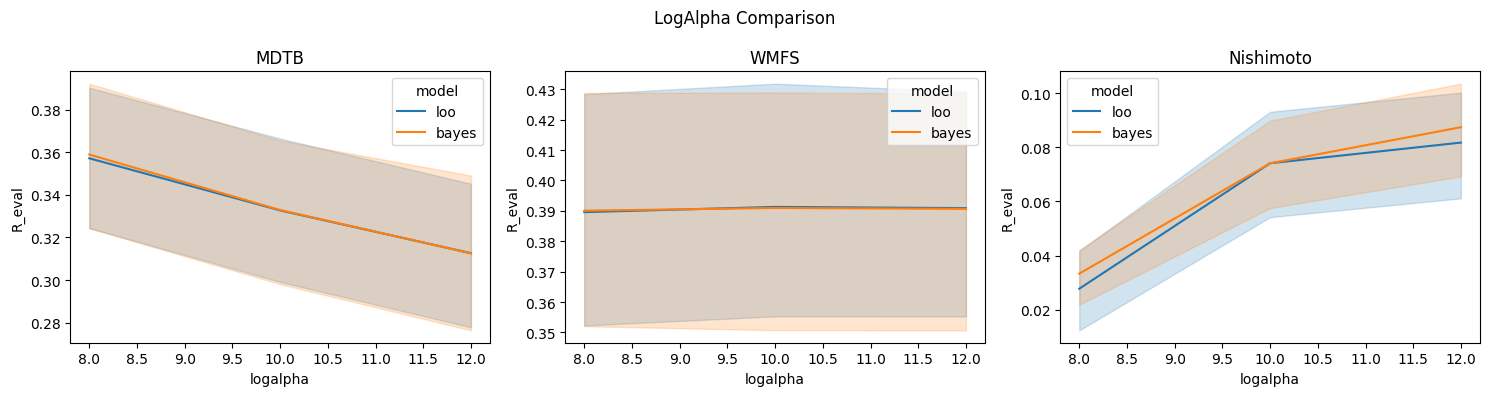

In [9]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df[df['eval_dataset'] == dataset]
    means = df_to_eval.groupby('model')['R_eval'].mean().sort_values(ascending=True)
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [10]:
A = pd.pivot_table(df,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df['isbest'] = df.logalpha.values  == bestla.loc[df.train_dataset].values.flatten()

R_eval                    
logalpha           8.0       10.0      12.0
train_dataset                              
MDTB           0.358145  0.332838  0.312590
Nishimoto      0.030535  0.074069  0.084544
WMFS           0.389808  0.391126  0.390773

,best_logalpha
train_dataset,
MDTB,8.0
Nishimoto,12.0
WMFS,10.0


/tmp/ipykernel_2337503/1618636403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isbest'] = df.logalpha.values  == bestla.loc[df.train_dataset].values.flatten()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

loo vs. bayes: t-test paired samples, P_val:1.596e-02 t=-2.601e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bayes vs. loo: t-test paired samples, P_val:8.612e-01 t=-1.779e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

loo vs. bayes: t-test paired samples, P_val:1.924e-02 t=-3.401e+00


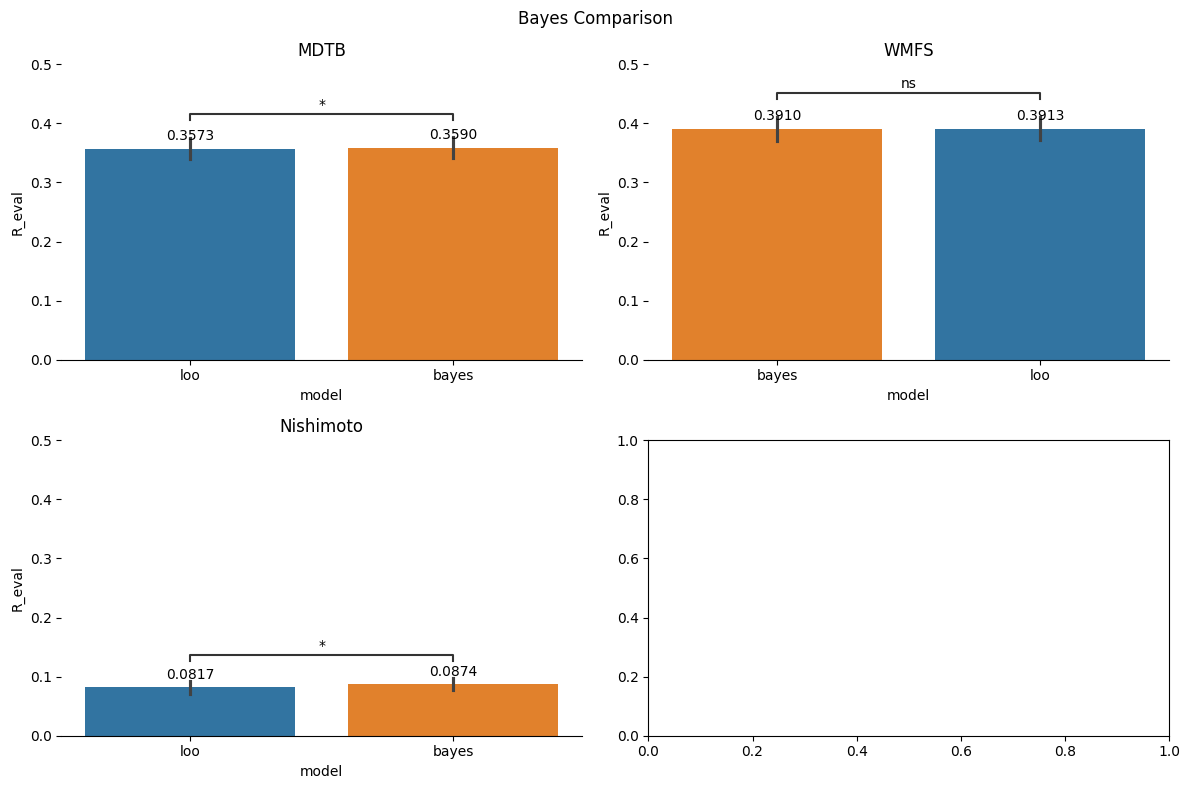

In [11]:
pairs=[('loo', 'bayes')]

plt.subplots(int(np.ceil(len(dataset_list)/2)),2,figsize=(12,int(np.ceil(len(dataset_list)/2))*4))
plt.suptitle('Bayes Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/2)),2,d+1)
    df_to_eval = df[(df['eval_dataset'] == dataset) & (df['isbest'])]
    ax, means = plot_with_error(df=df_to_eval, x_var='model', y_var='R_eval', title=dataset)
    plt.ylim([0, 0.5])

    # significance test
    annotator = Annotator(ax, pairs, data=df_to_eval, x='model', y='R_eval', order=means.index.to_list())
    annotator.configure(test='t-test_paired', text_format='star', loc='inside')
    annotator.apply_and_annotate()
plt.tight_layout()

### Improved Bayes using $\sigma^2_m$ estimation

In [11]:
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])
    
    df = rm.comb_eval(models=[dataset_name+"-bayes"],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-bayes"
    df_all = pd.concat([df_all, df])

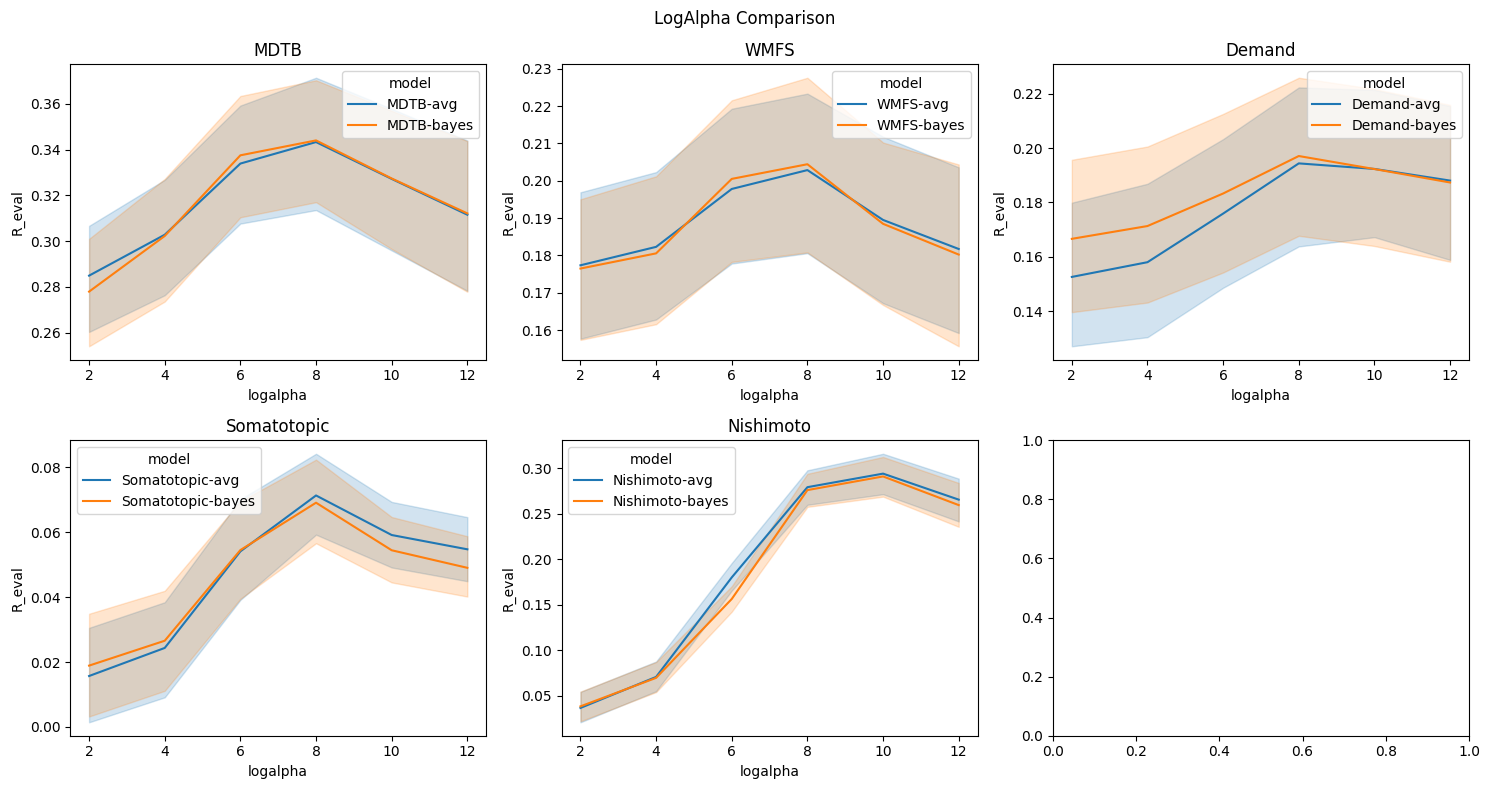

In [12]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df_all[df_all['train_dataset'] == dataset]
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [13]:
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval']).reindex(dataset_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.281415  0.302526  0.335733  0.343697  0.327313  0.311845
WMFS           0.176911  0.181413  0.199149  0.203642  0.188980  0.180967
Demand         0.159652  0.164707  0.179608  0.195710  0.192298  0.187689
Somatotopic    0.017300  0.025459  0.054305  0.070217  0.056796  0.051888
Nishimoto      0.037384  0.070132  0.168243  0.277739  0.292711  0.262642

,best_logalpha
train_dataset,
MDTB,8.0
WMFS,8.0
Demand,8.0
Somatotopic,8.0
Nishimoto,10.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-avg vs. MDTB-bayes: t-test paired samples, P_val:8.465e-02 t=-1.846e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-avg vs. MDTB-bayes: t-test paired samples, P_val:1.438e-02 t=-2.572e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-avg vs. MDTB-bayes: t-test paired samples, P_val:1.606e-02 t=3.154e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MD

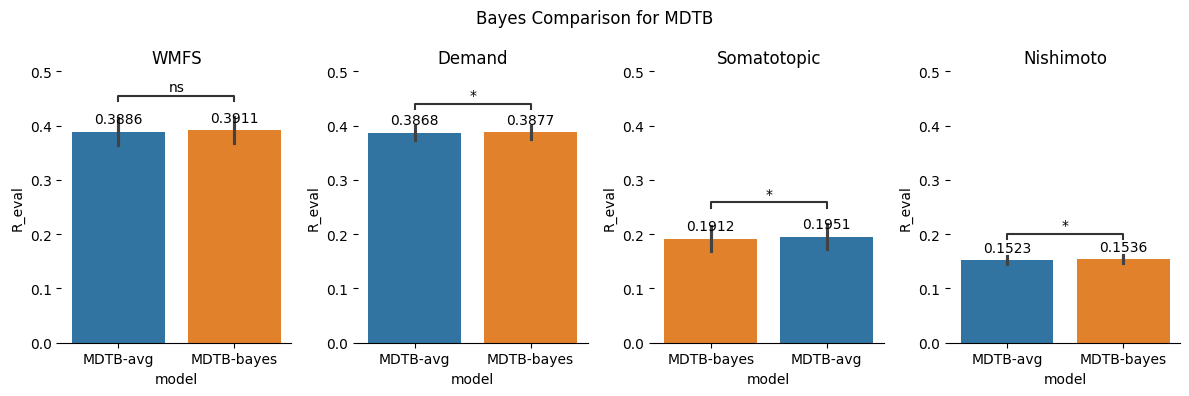

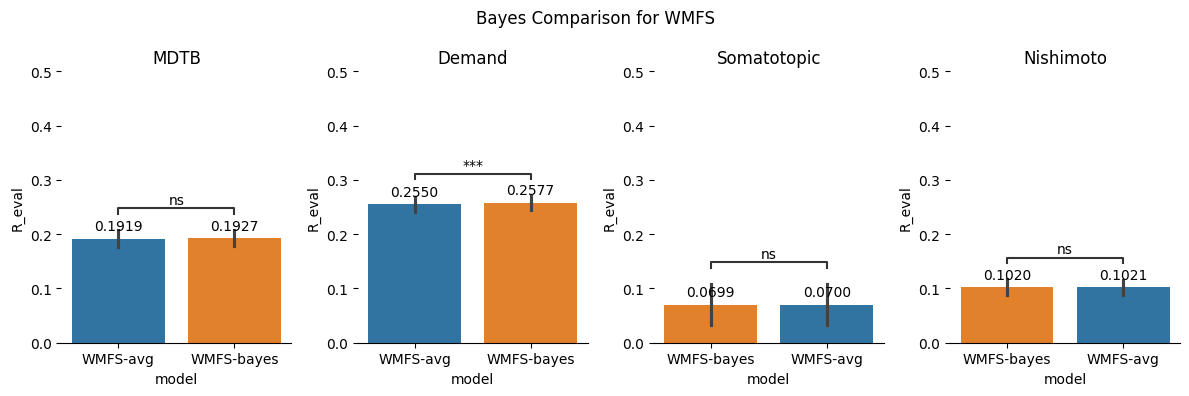

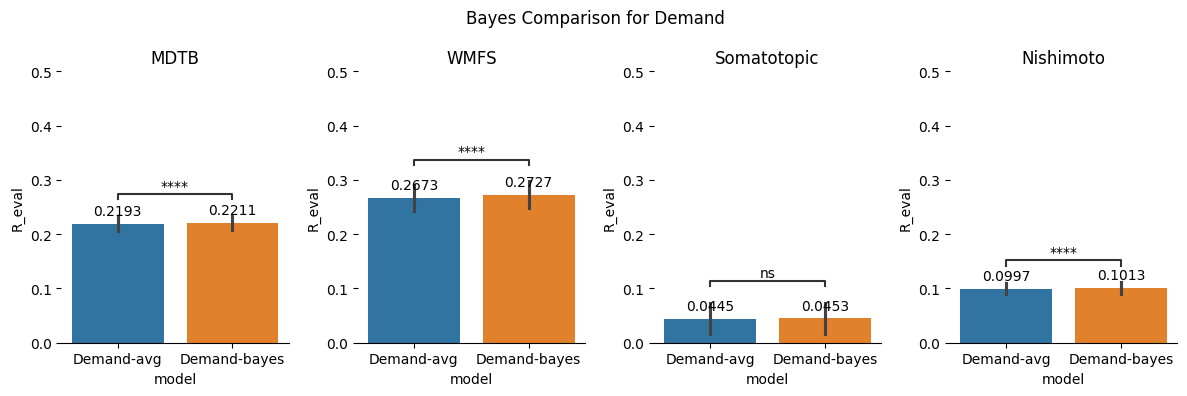

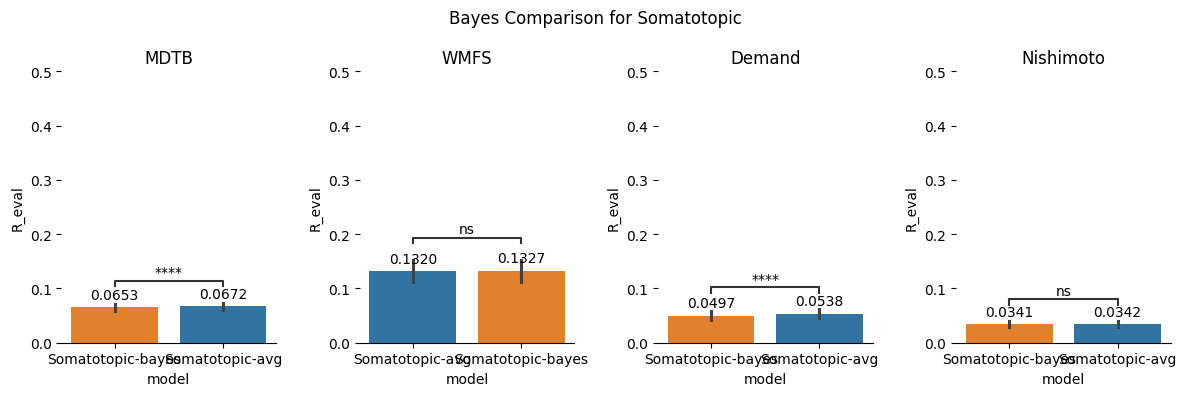

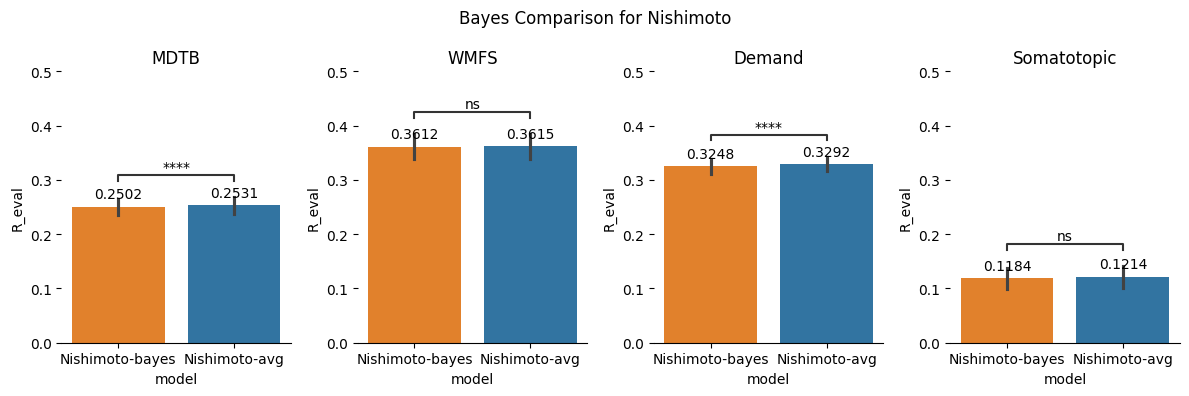

In [14]:
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]
    pairs=[(dataset_name+"-avg", dataset_name+"-bayes")]

    plt.subplots(1,4,figsize=(12,4))
    plt.suptitle("Bayes Comparison for "+dataset_name)
    for d,dataset in enumerate(eval_data):
        plt.subplot(1,4,d+1)
        df_to_eval = df_all[(df_all['train_dataset'] == dataset_name) & (df_all['eval_dataset'] == dataset) & (df_all['isbest'])]
        ax, means = plot_with_error(df=df_to_eval, x_var='model', y_var='R_eval', title=dataset)
        # sns.boxplot(df_to_eval, x='model', y='R_eval')
        # plt.title(dataset)
        plt.ylim([0, 0.5])

        # significance test
        annotator = Annotator(ax, pairs, data=df_to_eval, x='model', y='R_eval')#, order=means.index.to_list())
        annotator.configure(test='t-test_paired', text_format='star', loc='inside')
        annotator.apply_and_annotate()
    plt.tight_layout()

Text(0, 0.5, 'Eval Dataset')

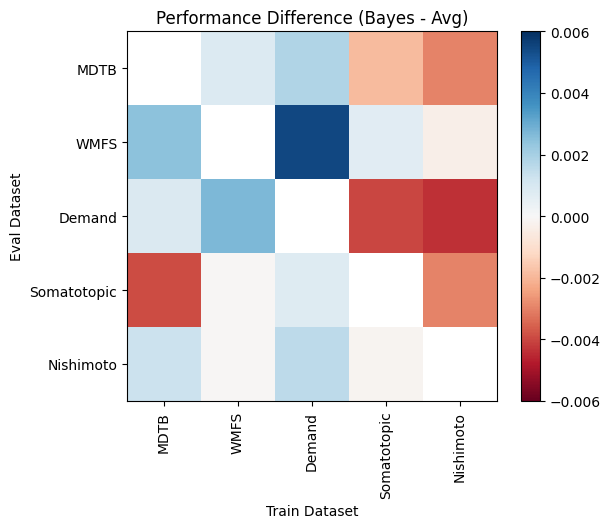

In [15]:
df_to_eval = df_all[(df_all['model'].str.contains('avg', case=False, na=False)) & df_all['isbest']]
model_avg_pivot = pd.pivot_table(df_to_eval,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])

df_to_eval = df_all[(df_all['model'].str.contains('bayes', case=False, na=False)) & df_all['isbest']]
model_bayes_pivot = pd.pivot_table(df_to_eval,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])

diff_pivot = model_bayes_pivot - model_avg_pivot
diff_pivot = diff_pivot.reindex(dataset_list, axis=0)
diff_pivot = diff_pivot.reindex(dataset_list, level=1, axis=1)

plt.imshow(diff_pivot.values,cmap='RdBu',vmin=-0.006,vmax=0.006)
ax=plt.gca()
plt.xticks(np.arange(5),diff_pivot.columns.values)
ax.set_xticklabels(diff_pivot.columns.get_level_values(1).values, rotation = 90)
plt.yticks(np.arange(5),diff_pivot.index.values)
plt.colorbar()

plt.title('Performance Difference (Bayes - Avg)')
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')

### Improved Bayes using half estimation

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "Fus"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = []
    for eval_ds in dataset_list:
        if eval_ds!=dataset_name:
            if (eval_ds!='Fus') & (eval_ds!='Language'):
                eval_data.append(eval_ds)
            elif eval_ds=='Language':
                eval_data.append('Languagelocalizer_cond')

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
    if dataset_name=='Fus':
        df['train_dataset'] = 'Fus'
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df])

    # Load loo performances
    if dataset_name!='Fus':
        df = rm.comb_eval(models=[dataset_name+"-loo"],methods=['L2reghalf'],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
        df['model'] = dataset_name+"-loo"
        df_all = pd.concat([df_all, df])
    
    # Load bayes performances
    if dataset_name!='Fus':
        df = rm.comb_eval(models=[dataset_name+"-bayes"],methods=['L2reghalf'],eval_data=eval_data,cerebellum='MNISymC3')
        df['model'] = dataset_name+"-bayes"
        df_all = pd.concat([df_all, df])

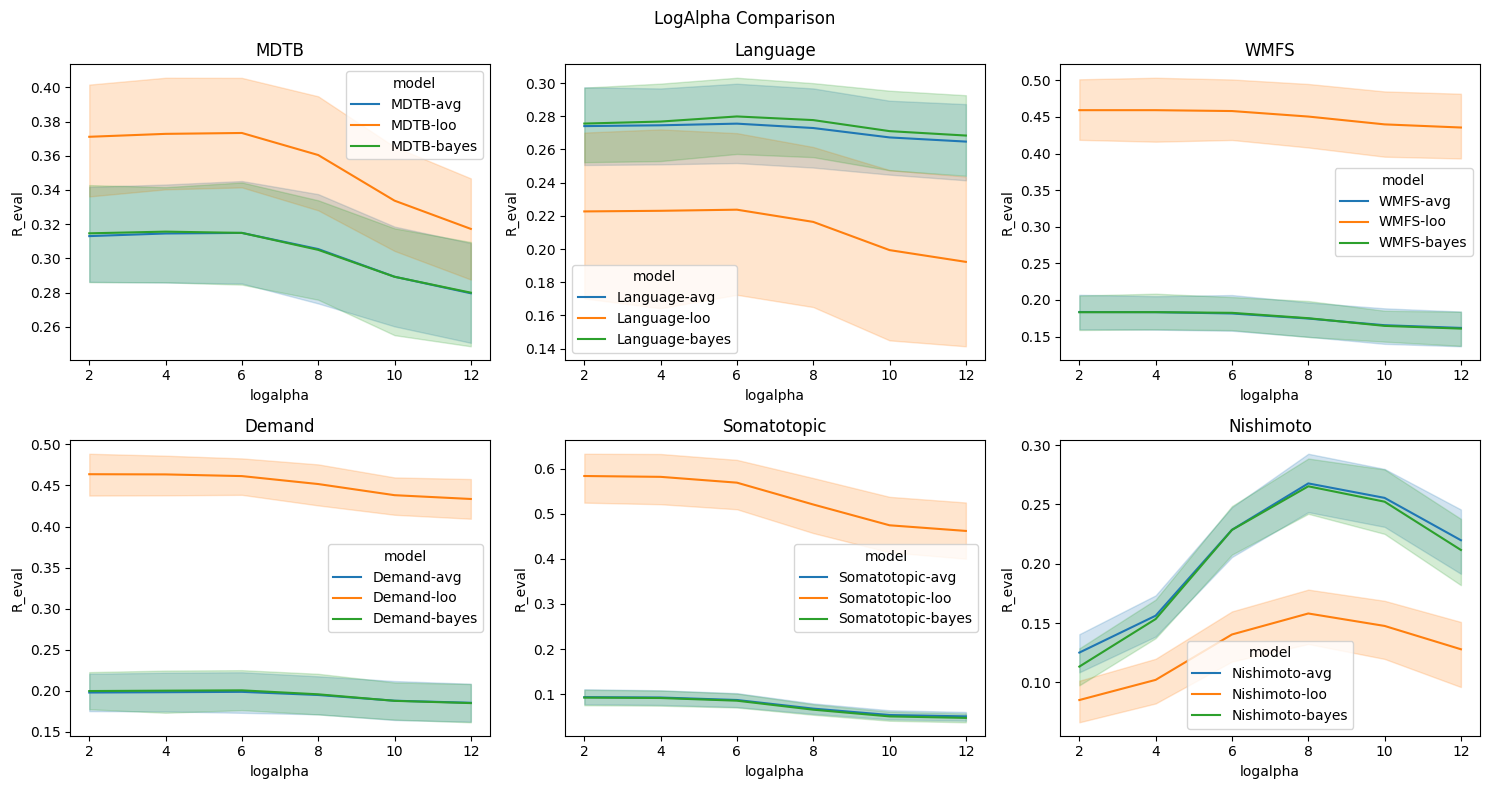

In [4]:
df_no_fuse = df_all[~df_all['model'].str.contains("Fus")]
plt.subplots(int(np.ceil(len(dataset_list[:-1])/3)),3,figsize=(15,int(np.ceil(len(dataset_list[:-1])/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list[:-1]):
    plt.subplot(int(np.ceil(len(dataset_list[:-1])/3)),3,d+1)
    df_to_eval = df_no_fuse[df_no_fuse['train_dataset'] == dataset]
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

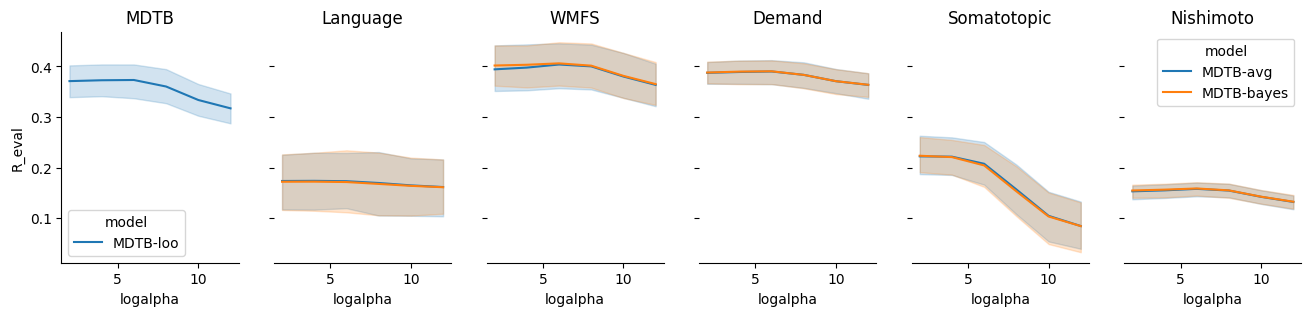

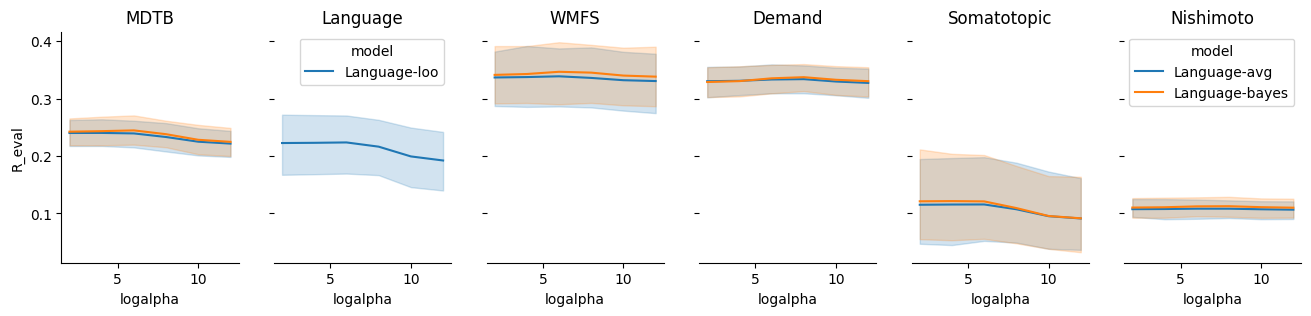

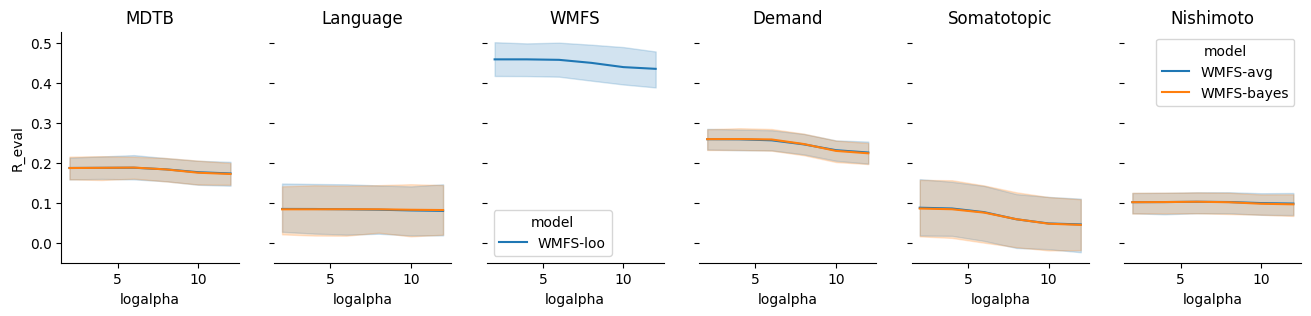

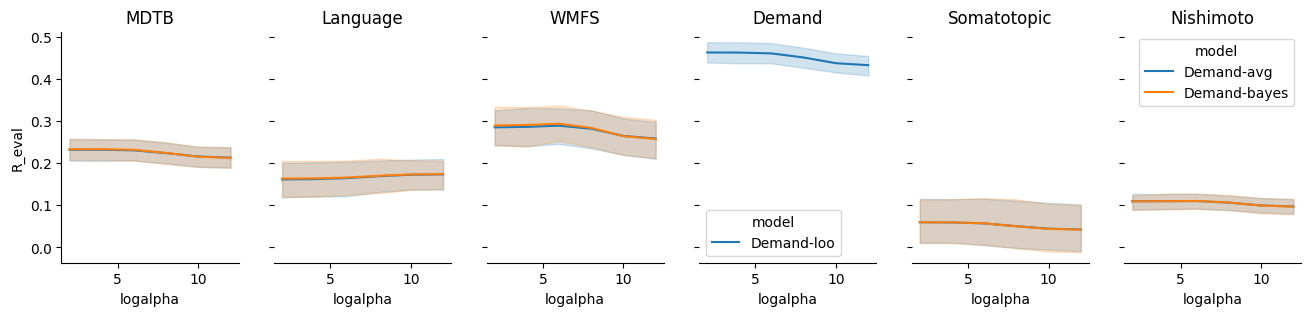

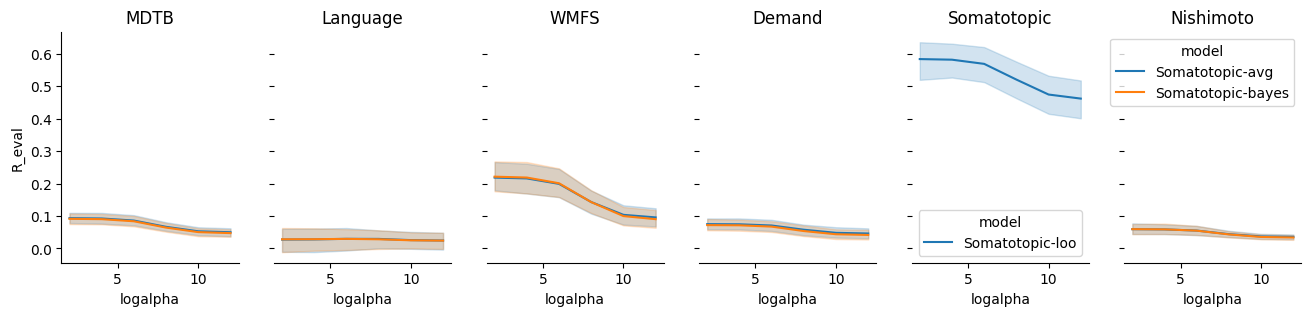

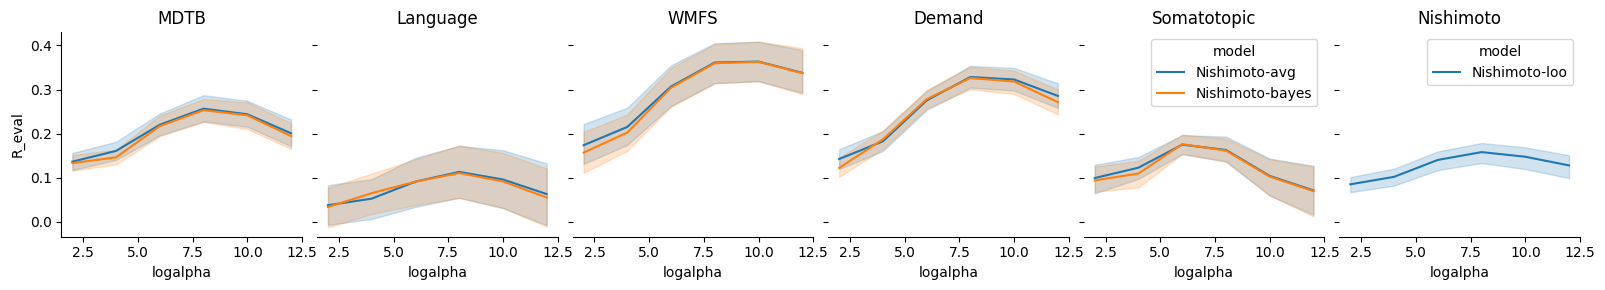

In [5]:
for tdata in dataset_list[:-1]:
    plt.subplots(1,6,figsize=(16,3), sharey=True)
    # plt.suptitle(f'LogAlpha Comparison for {tdata}')

    count = 0
    for d,edata in enumerate(dataset_list[:-1]):
        plt.subplot(1,6,d+1)
        df_to_eval = df_no_fuse[(df_no_fuse['train_dataset'] == tdata) & (df_no_fuse['eval_dataset'] == edata)]
        ax = sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
        plt.title(edata)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if d!=0:
            ax.spines['left'].set_visible(False)
        if (tdata != edata):
            count+=1
        if (tdata != edata) & (count!=5):
            ax.legend().set_visible(False)
plt.tight_layout()

In [6]:
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval']).reindex(dataset_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = (df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()) | (df_all.train_dataset.str.contains('Fus'))

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.321018  0.322334  0.322224  0.312148  0.294865  0.284502
Language       0.270361  0.271170  0.273087  0.270250  0.263165  0.260198
WMFS           0.205428  0.205368  0.204030  0.196871  0.186989  0.183252
Demand         0.253417  0.253685  0.253600  0.248158  0.239435  0.236391
Somatotopic    0.111612  0.110732  0.104717  0.084054  0.068283  0.064748
Nishimoto      0.118172  0.153271  0.226082  0.263464  0.250925  0.213224
Fus                 NaN       NaN       NaN       NaN       NaN       NaN

,best_logalpha
train_dataset,
MDTB,4.0
Language,6.0
WMFS,2.0
Demand,4.0
Somatotopic,2.0
Nishimoto,8.0
Fus,2.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-bayes vs. MDTB-avg: t-test paired samples, P_val:1.234e-01 t=-1.626e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-avg vs. MDTB-bayes: t-test paired samples, P_val:1.032e-03 t=-4.057e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MDTB-avg vs. MDTB-bayes: t-test paired samples, P_val:4.829e-02 t=-2.044e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M

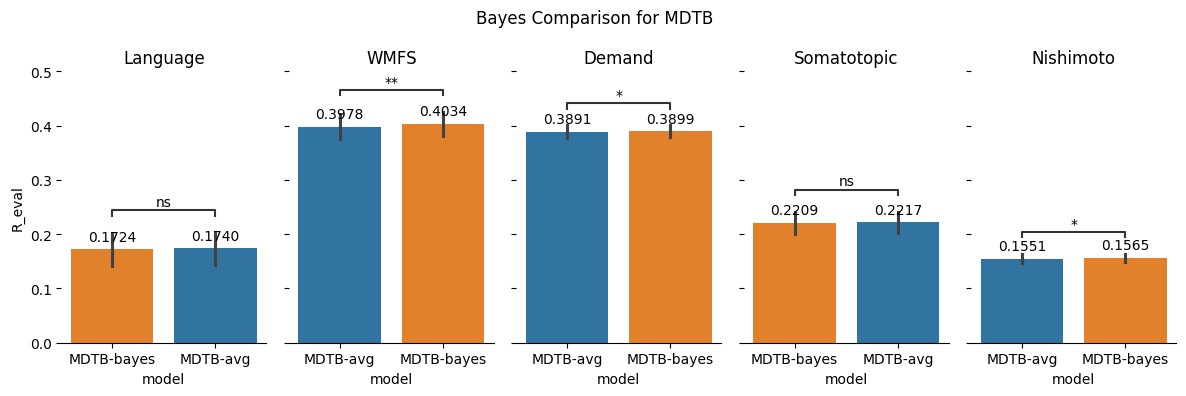

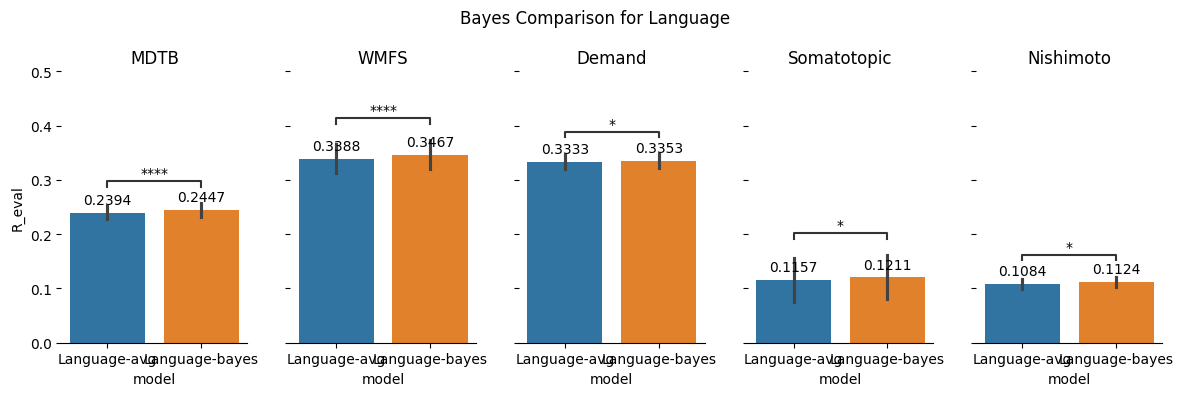

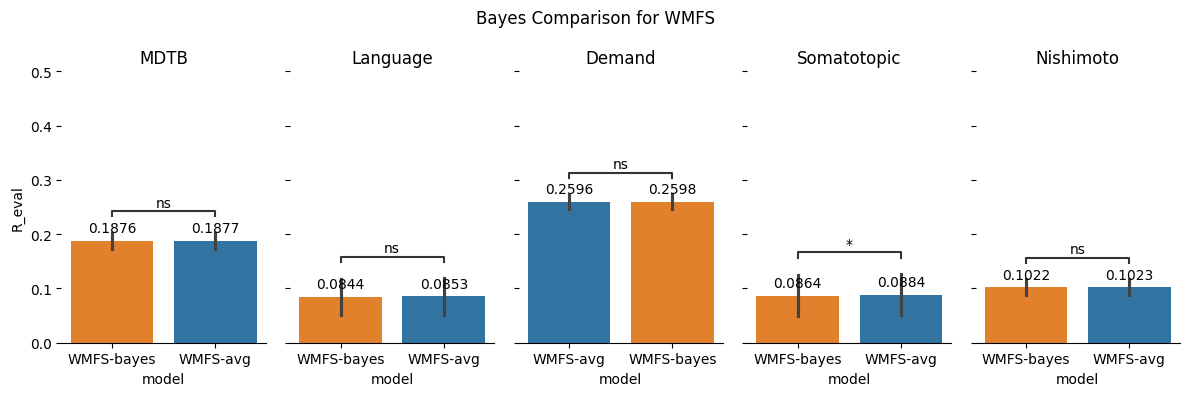

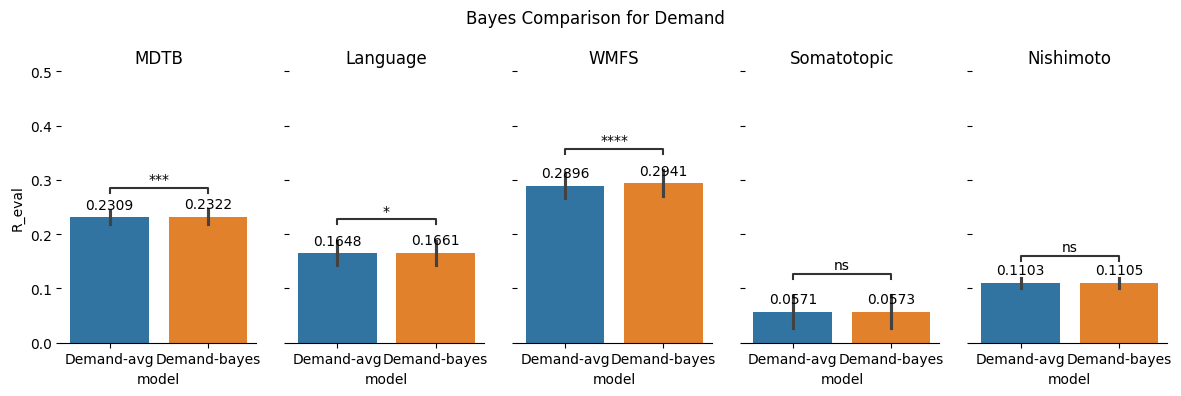

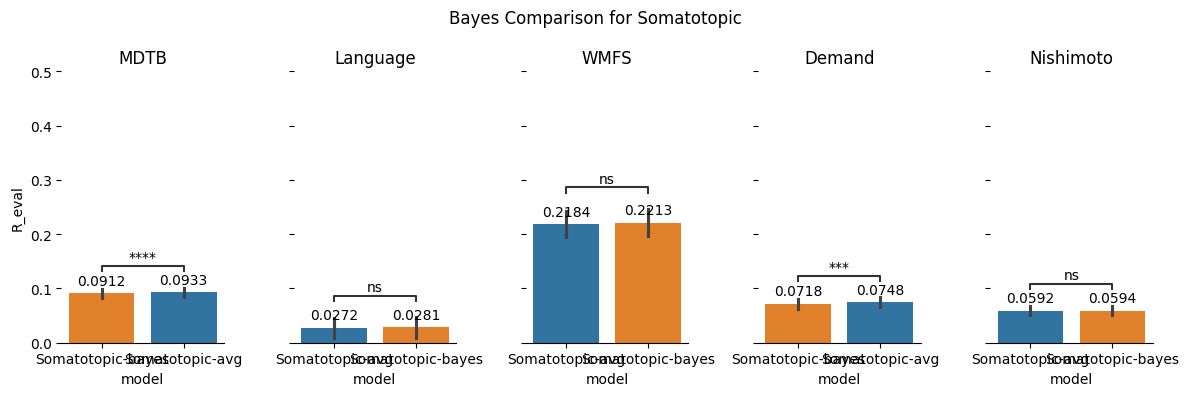

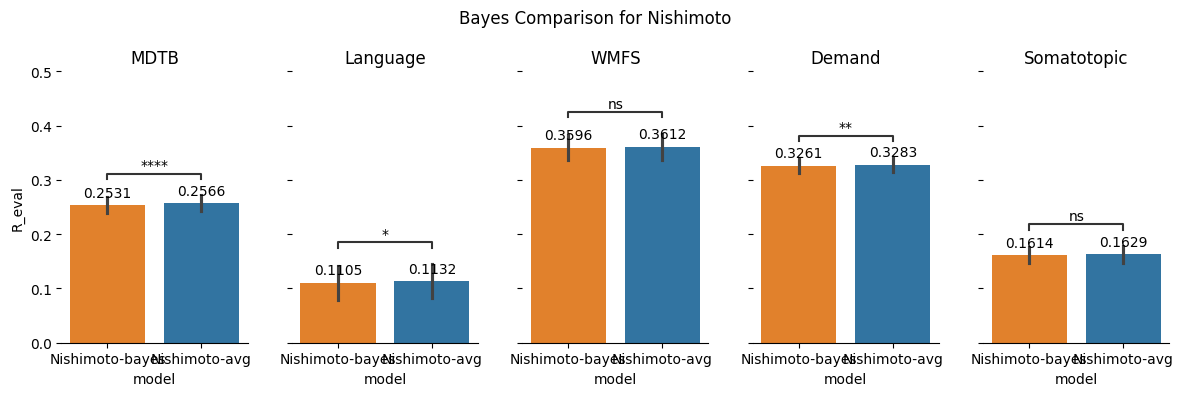

In [22]:
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]
    pairs=[(dataset_name+"-avg", dataset_name+"-bayes")]

    plt.subplots(1,5,figsize=(12,4), sharey=True)
    plt.suptitle("Bayes Comparison for "+dataset_name)
    for d,dataset in enumerate(eval_data):
        plt.subplot(1,5,d+1)
        df_to_eval = df_no_fuse[(df_no_fuse['train_dataset'] == dataset_name) & (df_no_fuse['eval_dataset'] == dataset) & (df_no_fuse['isbest'])]
        ax, means = plot_with_error(df=df_to_eval, x_var='model', y_var='R_eval', title=dataset)
        # sns.boxplot(df_to_eval, x='model', y='R_eval')
        # plt.title(dataset)
        if d!=0:
            ax.set_ylabel([])
        plt.ylim([0, 0.5])

        # significance test
        annotator = Annotator(ax, pairs, data=df_to_eval, x='model', y='R_eval', order=means.index.to_list())
        annotator.configure(test='t-test_paired', text_format='star', loc='inside')
        annotator.apply_and_annotate()
    plt.tight_layout()

Text(0, 0.5, 'Eval Dataset')

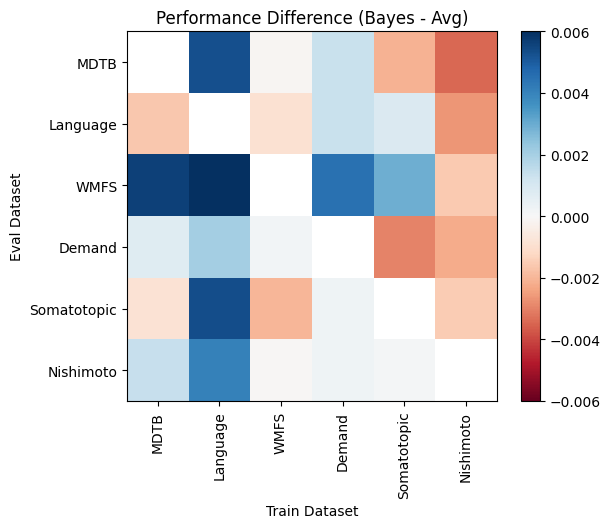

In [23]:
df_to_eval = df_all[(df_all['model'].str.contains('avg', case=False, na=False)) & df_all['isbest']]
model_avg_pivot = pd.pivot_table(df_to_eval,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])

df_to_eval = df_all[(df_all['model'].str.contains('bayes', case=False, na=False)) & df_all['isbest']]
model_bayes_pivot = pd.pivot_table(df_to_eval,columns=['train_dataset'],index=['eval_dataset'],values=['R_eval'])

diff_pivot = model_bayes_pivot - model_avg_pivot
diff_pivot = diff_pivot.reindex(dataset_list, axis=0)
diff_pivot = diff_pivot.reindex(dataset_list, level=1, axis=1)

plt.imshow(diff_pivot.values,cmap='RdBu',vmin=-0.006,vmax=0.006)
ax=plt.gca()
plt.xticks(np.arange(6),diff_pivot.columns.values)
ax.set_xticklabels(diff_pivot.columns.get_level_values(1).values, rotation = 90)
plt.yticks(np.arange(6),diff_pivot.index.values)
plt.colorbar()

plt.title('Performance Difference (Bayes - Avg)')
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')

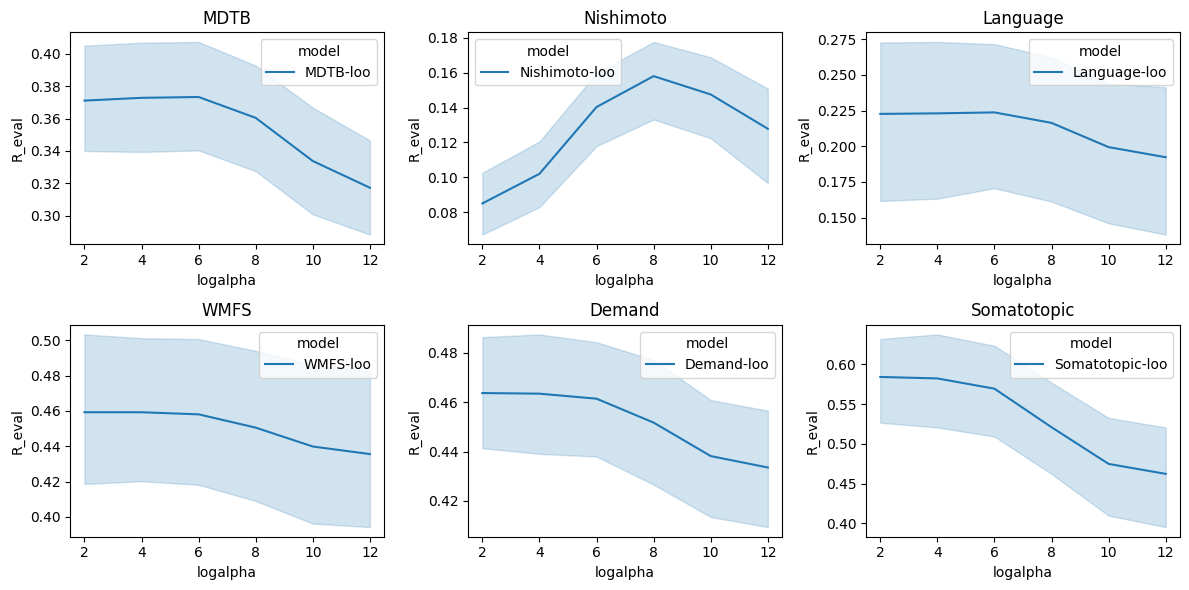

In [11]:
plt.figure(figsize=(12,6))
evd=['MDTB','Nishimoto','Language','WMFS','Demand','Somatotopic']

for i,ed in enumerate(evd):
    ax=plt.subplot(2,3,i+1)
    d=df_all[(df_all.eval_dataset==ed) & (df_all.train_dataset==ed)]
    plt.title(ed)
    sns.lineplot(data=d,y='R_eval',x='logalpha',hue='model')
plt.tight_layout()